In [3]:
import load_files as lf
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import seaborn as sns
import datetime

In [4]:
flow_data_DRU, level_data_DRU = lf.get_measurements("D:/waterschap-aa-en-maas_sewage_2019/sewer_data/data_pump/RG8150/RG8150")
flow_data_HAA, level_data_HAA = lf.get_measurements("D:/waterschap-aa-en-maas_sewage_2019/sewer_data/data_pump/RG8170/RG8170")
rain_data = lf.get_rain("D:/waterschap-aa-en-maas_sewage_2019/sewer_data/rain_timeseries")
data = lf.sdf("D:/waterschap-aa-en-maas_sewage_2019/sewer_model/aa-en-maas_sewer_shp")

In [93]:
def reset_cumsum(lst, threshold=0, count=True):
    output = [0]
    for i in range(1, len(lst)):
        if count:
            output = output + [0 if lst[i] >= threshold else output[i-1] + 1]
        else:
            output = output + [0 if lst[i] >= threshold else output[i-1] + lst[i]]
    
    return pd.Series(output, index=lst.index)


def summarize_rain_data(rain_data, area_data=None, village_code=None, dry_threshold=0):
    if rain_data["Start"].dtype != "<M8[ns]":
            rain_data["Start"] = pd.to_datetime(rain_data["Start"])
    
    rain_data.sort_values("Start", inplace=True)
    rain_data.reset_index(drop=True, inplace=True)
    
    if village_code is not None:
        area_data["village_ID"] = area_data["sewer_system"].str.slice(4,7)
        area_data = area_data.loc[area_data["village_ID"] == village_code]
        areas = area_data["area_name"][area_data["area_name"].apply(lambda i: i in rain_data.columns)].to_list()
        
        rain_data = rain_data.loc[:, ["Start", "End"] + areas]
    
    rain_data["Date"] = rain_data["Start"].apply(lambda i: i.date())
    rain_data["Total"] = rain_data.iloc[:, 2:].mean(axis=1)
    
    rain_data = rain_data.groupby("Date")["Total"].sum().reset_index(drop=False)
    rain_data["DrySeries"] = reset_cumsum(rain_data["Total"], dry_threshold)
    
    return rain_data


class measurement_analysis:
    def __init__(self, flow_data, level_data, rain_data,
                 min_dry_series=1, area_data=None, village_code=None, dry_threshold=0, max_interval=None):
        # CLEAN DATA
        # Check wether data has right format and if not make necessary transformations
        
        # Transform TimeStamp column to datetime
        if flow_data["TimeStamp"].dtype != "<M8[ns]":
            flow_data["TimeStamp"] = pd.to_datetime(flow_data["TimeStamp"])
            
        flow_data.sort_values("TimeStamp", inplace=True)
        flow_data.reset_index(drop=True, inplace=True)    
        
        if level_data["TimeStamp"].dtype != "<M8[ns]":
            level_data["TimeStamp"] = pd.to_datetime(level_data["TimeStamp"])
            
        level_data.sort_values("TimeStamp", inplace=True)
        level_data.reset_index(drop=True, inplace=True)
        
        # Check if rain_data is already summarized
        if not all(i in rain_data.columns for i in ['Date', 'Total', 'DrySeries']):
            rain_data = summarize_rain_data(rain_data, area_data, village_code, dry_threshold)
            
        flow_data["Date"] = flow_data["TimeStamp"].apply(lambda i: i.date())
        flow_data["Hour"] = flow_data["TimeStamp"].apply(lambda i: i.hour)
        flow_data["Month"] = flow_data["Date"].apply(lambda i: i.month)
        flow_data["Weekend"] = flow_data["Date"].apply(lambda i: int(i.weekday() >= 5))
        flow_data["TimeSpan"] = flow_data["TimeStamp"].diff(1).apply(lambda i: i.seconds).fillna(5)
        flow_data["Freq"] = 1 / flow_data["TimeSpan"]
        flow_data["Flow"] = flow_data["Value"] * flow_data["TimeSpan"] / 3600
        
        flow_data["max"] = ((flow_data["Value"].diff(1) > 0) & (flow_data["Value"].diff(-1) > 0)).astype(int)
        flow_data["min"] = ((flow_data["Value"].diff(1) < 0) & (flow_data["Value"].diff(-1) < 0)).astype(int)
        
        level_data["Date"] = level_data["TimeStamp"].apply(lambda i: i.date())
        level_data["Hour"] = level_data["TimeStamp"].apply(lambda i: i.hour)
        level_data["Month"] = level_data["Date"].apply(lambda i: i.month)
        level_data["Weekend"] = level_data["Date"].apply(lambda i: int(i.weekday() >= 5))
        level_data["TimeSpan"] = level_data["TimeStamp"].diff(1).apply(lambda i: i.seconds)
        level_data["Freq"] = 1 / level_data["TimeSpan"]
        level_data["Delta"] = level_data["Value"].diff(1)
        
        level_data["max"] = ((level_data["Value"].diff(1) > 0) & (level_data["Value"].diff(-1) > 0)).astype(int)
        level_data["min"] = ((level_data["Value"].diff(1) < 0) & (level_data["Value"].diff(-1) < 0)).astype(int)
        
        # Additional Measures
        self.area = area_data.loc[area_data["village_ID"] == village_code, "geometry"]\
                                 .to_crs({"init": "epsg:3395"}).map(lambda p: p.area / 10**6).sum()
        
        # STORE DATA
        self.min_dry_series = min_dry_series
        self.area_data = area_data
        self.village_code = village_code
        self.dry_threshold = dry_threshold
        self.max_interval = max_interval
        
        self.flow_data = flow_data
        self.level_data = level_data
        self.rain_data = rain_data

    def plot(self):
        plt.figure(figsize=(14, 7))
        
        plt.subplot(4, 2, 1)
        flow = self.flow_data["Value"].plot()
        plt.subplot(4, 2, 2)
        level = self.level_data["Value"].plot()
        
        plt.subplot(4, 2, 3)
        flow_by_time = self.flow_data.groupby("Hour")["Flow"].sum().plot()
        plt.subplot(4, 2, 5)
        flow_by_month = self.flow_data.groupby("Month")["Flow"].sum().plot()
        
        plt.subplot(4, 2, 4)
        mean_level_by_hour = self.level_data.groupby("Hour")["Value"].mean().plot()
        plt.subplot(4, 2, 6)
        mean_level_by_month = self.level_data.groupby("Month")["Value"].mean().plot()
        
        plt.subplot(4, 2, 7)
        rain_flow_merge = pd.merge(self.flow_data.groupby("Date")["Flow"].sum(),
                                   self.rain_data.set_index("Date"), left_index=True, right_index=True)
        rain_flow_merge = rain_flow_merge.loc[rain_flow_merge["Total"] <= 15]
        sns.regplot(y = rain_flow_merge["Flow"], x = rain_flow_merge["Total"], order=2)
        plt.subplot(4, 2, 8)
        self.rain_data.set_index("Date")["Total"].plot()
        
        plt.tight_layout()
        plt.show()
    
    def DWAAS_HAAS(self):
        dry_dates = self.rain_data.loc[self.rain_data["DrySeries"] >= self.dry_threshold, "Date"]
        rainy_dates = self.rain_data.loc[self.rain_data["DrySeries"] == 0, "Date"]
        
        self.flow_data["Dry"] = self.flow_data["TimeStamp"].apply(lambda i: i.date() in dry_dates.to_list()).astype(int)
        
        dry_flow = self.flow_data.loc[self.flow_data["Dry"] == 1]
        
        measure_names = ["Theoretical DWF (Q80)",
                         "Summer",
                         "Winter",
                         "Workday",
                         "Weekend",
                         "Average"]

        measures = [dry_flow.groupby("Date")["Flow"].sum().quantile(0.2),
                    dry_flow.loc[dry_flow["Month"] <= 3].groupby("Date")["Flow"].sum().mean(),
                    dry_flow.loc[(dry_flow["Month"] >= 6) & (dry_flow["Month"] <= 9)].groupby("Date")["Flow"].sum().mean(),
                    dry_flow.loc[dry_flow["Weekend"] == 0].groupby("Date")["Flow"].sum().mean(),
                    dry_flow.loc[dry_flow["Weekend"] == 1].groupby("Date")["Flow"].sum().mean(),
                    dry_flow.groupby("Date")["Flow"].sum().mean()
                   ]
        
        relative_measures = [1,
                             measures[1] / measures[0],
                             measures[2] / measures[0],
                             measures[3] / measures[0],
                             measures[4] / measures[0],
                             measures[5] / measures[0]
                            ]
        
        DWAAS_table1 = pd.DataFrame({"Name": measure_names, "Value": measures, "Rel. Value": relative_measures})
        
        return DWAAS_table1

In [90]:
yo = measurement_analysis(flow_data_DRU, level_data_DRU, rain_data,
                     min_dry_series=3, area_data=data.area_data, village_code="DRU", dry_threshold=2.5, max_interval=120)
x = yo.DWAAS_HAAS()

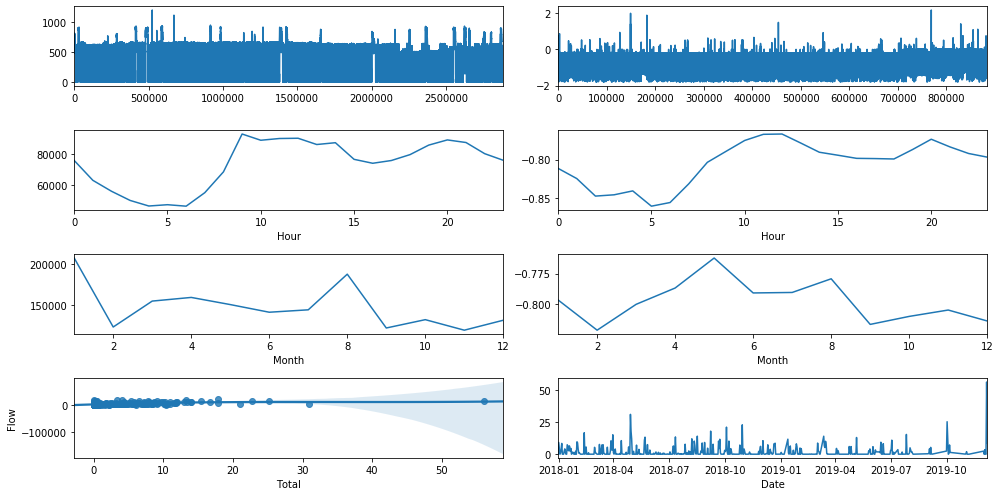

In [91]:
yo.plot()

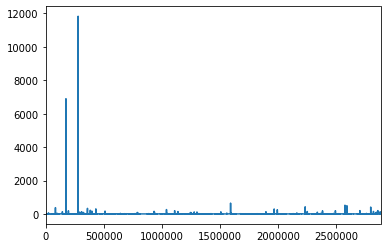

In [92]:
yo.flow_data["Flow"].plot()